# Projekt: Medikamentenempfehlung mittels Klassifikation

Stellen Sie sich vor, Sie sind ein medizinischer Forscher, der Daten für eine Studie zusammenstellt. Sie haben Daten über eine Reihe von Patienten gesammelt, die alle an derselben Krankheit litten. Während des Behandlungsverlaufs sprach jeder Patient auf eines von 5 Medikationen an, Medikament A, Medikament B, Medikament c, Medikament x und y.

Ein Teil Ihrer Arbeit besteht darin, ein Modell zu bauen, um herauszufinden, welches Medikament für einen zukünftigen Patienten mit derselben Krankheit geeignet sein könnte. Die Merkmalssätze dieses Datensatzes sind Alter, Geschlecht, Blutdruck und Cholesterin der Patienten, und das Ziel ist das Medikament, auf das jeder Patient angesprochen hat.

Das Projekt ist ein Beispiel für ein Klassifikationsmodell mit mehreren Klassen. Erstellen, trainieren und testen Sie ein Logistische Regression- und ein SVC-Modell. Erstellen Sie eine Vorhersage für die Klasse eines unbekannten Patienten, welches Medikament sollte diesem verschrieben werden.

Vergleichen Sie die beiden Modellleistungen, welches hat besser abgeschnitten ?

Für die Datenquelle siehe [hier](https://www.kaggle.com/code/gorkemgunay/drug-classification-with-different-algorithms/notebook)

In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [391]:
df=pd.read_csv('drug.csv')
df.tail(15)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
185,57,F,NORMAL,NORMAL,25.893,drugY
186,70,M,HIGH,HIGH,9.849,drugB
187,47,M,HIGH,HIGH,10.403,drugA
188,65,M,HIGH,NORMAL,34.997,drugY
189,64,M,HIGH,NORMAL,20.932,drugY
190,58,M,HIGH,HIGH,18.991,drugY
191,23,M,HIGH,HIGH,8.011,drugA
192,72,M,LOW,HIGH,16.310,drugY
193,72,M,LOW,HIGH,6.769,drugC
194,46,F,HIGH,HIGH,34.686,drugY


### Datenaufbereitung
Wir haben hier einige kategorische Merkmale, die müssen wir entsprechend umwandeln (ihr müsst euch den Rückgabewert merken, Tip: seht euch für jede Umwandlung das Ergebnis erst einmal an):

In [292]:
# BSP für die Anwendung, muss von Euch angepasst werden
# pd.get_dummies(df['BP'],prefix='BLOOD', drop_first=True) # eine Spalte kann weggelassen werden, drop_first=True erledigt das (ihr könnt das auch weglassen, dann habt ihr halt redundante Spalten)

Manuelle Berechnung:

In [293]:
'''label_e= LabelEncoder()
df['Geschlecht'] = label_e.fit_transform(df['Sex'])# F = 0, M = 1
df.head(3)'''

"label_e= LabelEncoder()\ndf['Geschlecht'] = label_e.fit_transform(df['Sex'])# F = 0, M = 1\ndf.head(3)"

In [294]:
'''label_e= LabelEncoder()
df['BPnum'] = label_e.fit_transform(df['BP'])# 0 -HIGH, 1 - LoW, 2 - Normal
df.head(5)'''

"label_e= LabelEncoder()\ndf['BPnum'] = label_e.fit_transform(df['BP'])# 0 -HIGH, 1 - LoW, 2 - Normal\ndf.head(5)"

In [295]:
'''label_e= LabelEncoder()
df['Chol_num'] = label_e.fit_transform(df['Cholesterol'])# 0 -HIGH, 1 - Normal
df.tail(5)'''

"label_e= LabelEncoder()\ndf['Chol_num'] = label_e.fit_transform(df['Cholesterol'])# 0 -HIGH, 1 - Normal\ndf.tail(5)"

In [296]:
'''df_neu=df.drop(columns=['Sex', 'BP', 'Cholesterol'], inplace=False)
df_neu.head(3)'''

"df_neu=df.drop(columns=['Sex', 'BP', 'Cholesterol'], inplace=False)\ndf_neu.head(3)"

Umwandlung kategorischen Spalten in nummerische  mit einer Funktion:

In [392]:
def my_label_encoder(y):
    """
    Funktion zum Kodieren einer kategorischen Spalte in einem DataFrame.

    """
    le = LabelEncoder()
    df[y] = le.fit_transform(df[y])
    
    return df

In [393]:

print(my_label_encoder('Drug'), my_label_encoder('Sex'), my_label_encoder('BP'), my_label_encoder('Cholesterol'))

     Age  Sex  BP  Cholesterol  Na_to_K  Drug
0     23    0   0            0   25.355     4
1     47    1   1            0   13.093     2
2     47    1   1            0   10.114     2
3     28    0   2            0    7.798     3
4     61    0   1            0   18.043     4
..   ...  ...  ..          ...      ...   ...
195   56    0   1            0   11.567     2
196   16    1   1            0   12.006     2
197   52    1   2            0    9.894     3
198   23    1   2            1   14.020     3
199   40    0   1            1   11.349     3

[200 rows x 6 columns]      Age  Sex  BP  Cholesterol  Na_to_K  Drug
0     23    0   0            0   25.355     4
1     47    1   1            0   13.093     2
2     47    1   1            0   10.114     2
3     28    0   2            0    7.798     3
4     61    0   1            0   18.043     4
..   ...  ...  ..          ...      ...   ...
195   56    0   1            0   11.567     2
196   16    1   1            0   12.006     2
197   52  

Die Zielvariable kann auch mit einem Labelencoder umgewandelt werden. DIes verwendet man für ordinal skalierte Daten (Kategorien mit einer Rangordnung, z.B. Erster, Zweiter,... bei einem Wettbewerb). Da mit der Zielvariable nicht gerechnet wird kann für diese aber auch der Labelencoder eingesetzt werden, das spart Speicherplatz.<br>
Der Labelencoder erzeugt nicht für jedes Element eine eigene Spalte sondern ersetzt die verschiedenen Kategorien mit einer Zahl, z.B "rot", "grün", "blau" -> 2, 1, 0

In [299]:
'''# BSP für die Anwendung
dummy = pd.DataFrame({"spalte": ["rot", "grün", "blau"]})
encoder = LabelEncoder()
dummy["spalte"] = encoder.fit_transform(dummy['spalte'])
dummy'''

'# BSP für die Anwendung\ndummy = pd.DataFrame({"spalte": ["rot", "grün", "blau"]})\nencoder = LabelEncoder()\ndummy["spalte"] = encoder.fit_transform(dummy[\'spalte\'])\ndummy'

Manuelle Dekodierung:

In [132]:

'''my_enc = pd.DataFrame({"Geschlecht": ["F", "M"]})
my_encoder = LabelEncoder()
my_enc["Geschlecht"] = my_encoder.fit_transform(my_enc["Geschlecht"])
my_enc'''

,Geschlecht
0,0
1,1


In [133]:
'''my_encoder.inverse_transform(my_enc["Geschlecht"])'''

array(['F', 'M'], dtype=object)

In [134]:
'''my_enc = pd.DataFrame({"Chol_num": ["HIGH", "LOW", "NORMAL"]}) # 0 -HIGH, 1 - LoW, 2 - Normal
my_encoder = LabelEncoder()
my_enc["Chol_num"] = my_encoder.fit_transform(my_enc["Chol_num"])
my_enc'''

,Chol_num
0,0
1,1
2,2


In [135]:
'''my_encoder.inverse_transform(my_enc["Chol_num"])'''

array(['HIGH', 'LOW', 'NORMAL'], dtype=object)

In [136]:
'''my_enc = pd.DataFrame({"BPnum": ["HIGH", "NORMAL"]}) # 0 -HIGH, 1 - Normal
my_encoder = LabelEncoder()
my_enc["BPnum"] = my_encoder.fit_transform(my_enc["BPnum"])
my_enc'''

,BPnum
0,0
1,1


In [137]:
'''my_encoder.inverse_transform(my_enc["BPnum"])'''

array(['HIGH', 'NORMAL'], dtype=object)

Universelle Funktion, um kodieren und dekodieren:

In [170]:
'''def encoden_and_decoden_vom_column(data, column_name):
    """
    Universelle Funktion zum Kodieren und dekodieren einer Spalte von Dataframe

    """
    l_encoder = LabelEncoder()
    
    # Kodieren der Spalte
    data[column_name] = l_encoder.fit_transform(data[column_name])
    
    # Dekodieren
    decoded_column = l_encoder.inverse_transform(data[column_name])
    
    return data, l_encoder, decoded_column'''

In [171]:
'''encoden_and_decoden_vom_column(df,'Drug')'''

(     Age Sex      BP Cholesterol  Na_to_K  Drug
 0     23   F    HIGH        HIGH   25.355     4
 1     47   M     LOW        HIGH   13.093     2
 2     47   M     LOW        HIGH   10.114     2
 3     28   F  NORMAL        HIGH    7.798     3
 4     61   F     LOW        HIGH   18.043     4
 ..   ...  ..     ...         ...      ...   ...
 195   56   F     LOW        HIGH   11.567     2
 196   16   M     LOW        HIGH   12.006     2
 197   52   M  NORMAL        HIGH    9.894     3
 198   23   M  NORMAL      NORMAL   14.020     3
 199   40   F     LOW      NORMAL   11.349     3
 
 [200 rows x 6 columns],
 LabelEncoder(),
 array([4, 2, 2, 3, 4, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 4, 3, 0, 2, 4, 4, 4,
        4, 4, 4, 4, 4, 3, 4, 4, 3, 1, 3, 4, 3, 3, 0, 3, 3, 3, 4, 1, 4, 3,
        3, 3, 0, 2, 4, 4, 4, 3, 4, 4, 1, 2, 1, 4, 3, 4, 4, 0, 4, 3, 1, 4,
        0, 3, 4, 4, 1, 4, 3, 4, 4, 4, 0, 4, 0, 3, 1, 3, 2, 0, 2, 1, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 2, 3, 4, 3, 3, 4, 1, 4

Ursprüngliche Bezeichnungen wiederherstellen

In [84]:
'''encoder.inverse_transform(dummy['spalte'])'''

"encoder.inverse_transform(dummy['spalte'])"

### Modellerstellung
Erzeugt eine SVC und ein Logistisches Regressionsmodell, trainiert die beiden (Daten mittrain_test_split aufteilen) und vergleicht sie auf Grundlage der classification reports.  Erzeugt anschließend eine Vorhersage für jedes Modell. Benuzt dazu ein Beispiel aus dem Testset (also aus `X_test`, das Ergbnis steht im dazugehörigem `y_test`).<br>
Achtung, ihr müsst die entsprechenden Klassen erstmal importieren !

In [394]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix ,r2_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd


SVC-Model:

In [ ]:
#Erstellen von SCV:
#svc_modell = SVC(probability=True,max_iter=1000)

X = df.drop('Drug', axis='columns')
y = df['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''# Skalieren der Daten
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)'''

#Trainieren des Modells
svc_modell = SVC()
svc_modell.fit(X_train, y_train)

SVC()

In [439]:
# Testdaten erstellen
y_true = y_test # die wahren Werte
y_pred = svc_modell.predict(X_test) # die Voraussagen

In [440]:
#Confusion_matrix
conf_matrix = confusion_matrix(y_true,y_pred)
print(conf_matrix)

[[ 0  0  0  6  0]
 [ 0  0  0  3  0]
 [ 0  0  0  4  1]
 [ 0  0  0 10  1]
 [ 0  0  0  0 15]]


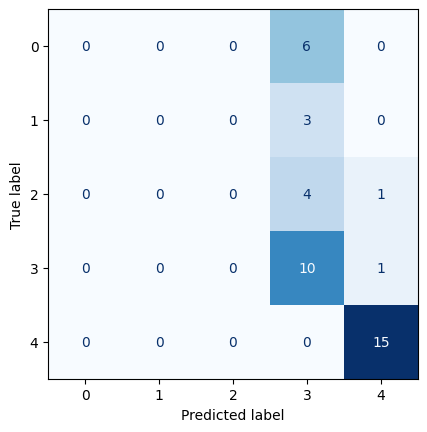

In [441]:
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap="Blues", colorbar=False)
plt.show()

In [442]:
y_test

95     3
15     4
30     3
158    2
128    4
115    4
69     4
170    3
174    0
45     3
66     0
182    3
165    4
78     0
186    1
177    4
56     1
152    3
82     2
68     4
124    1
16     3
148    3
93     4
65     4
60     4
84     2
67     3
125    4
132    3
9      4
18     2
55     2
75     4
150    0
104    4
135    3
137    0
164    4
76     0
Name: Drug, dtype: int64

In [443]:
y_pred

array([3, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3,
       3, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 3])

In [444]:
svc_modell.score(X_train,y_train)

0.70625

In [445]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.43      0.91      0.59        11
           4       0.88      1.00      0.94        15

    accuracy                           0.62        40
   macro avg       0.26      0.38      0.31        40
weighted avg       0.45      0.62      0.51        40



c:\Users\NataliaArchipenko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NataliaArchipenko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NataliaArchipenko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Logisches Model:

In [446]:
log_modell= LogisticRegression(max_iter=500)


In [447]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

log_modell.fit(X_train, y_train)

c:\Users\NataliaArchipenko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [448]:
log_modell.score(X_train, y_train)

0.9875

In [449]:
log_modell.score(X_test, y_test)

0.95

In [450]:
y_pred = log_modell.predict(X_test)
y_pred

array([3, 0, 3, 2, 4, 4, 4, 3, 0, 3, 0, 3, 4, 0, 1, 4, 1, 3, 2, 4, 1, 3,
       3, 4, 4, 4, 2, 3, 4, 3, 4, 2, 3, 4, 0, 4, 3, 0, 4, 0])

In [451]:
r2 = r2_score(y_test, y_pred)
print(f'R2-Wert: {r2:}')

R2-Wert: 0.7903822441430333


In [452]:
klas_report = classification_report(y_test, y_pred)
print(f'\tKlassifikationsreport von logischem Modell:\n\n{klas_report}')

	Klassifikationsreport von logischem Modell:

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       0.92      1.00      0.96        11
           4       1.00      0.93      0.97        15

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.96      0.95      0.95        40



In [458]:
# Vorhersagen für ganzen DataFrame
df['SVC_Prediction'] = svc_modell.predict(X)
df['Logistic_Prediction'] = log_modell.predict(X)

# Ausgabe der tatsächlichen und vorhergesagten Werte für beide Modelle für spalte Drug
print(df[['Drug', 'SVC_Prediction', 'Logistic_Prediction']].head(10))

#Für alle spalten:
#print(df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug', 'SVC_Prediction', 'Logistic_Prediction']].head(5))

# Genauigkeit der Modelle:
svc_ac = accuracy_score(y, df['SVC_Prediction'])
log_ac= accuracy_score(y, df['Logistic_Prediction'])

print(f"Genauegkeit von SVC Model: {svc_ac:.2f}")
print(f"Genauegkeit von Logistischem Regressionsmodell: {log_ac:.2f}")


   Drug  SVC_Prediction  Logistic_Prediction
0     4               4                    4
1     2               3                    2
2     2               3                    2
3     3               3                    3
4     4               4                    4
5     3               3                    3
6     4               4                    4
7     2               3                    2
8     4               4                    4
9     4               4                    4
Genauegkeit von SVC Model: 0.69
Genauegkeit von Logistischem Regressionsmodell: 0.98


In [485]:
print(min(3, abs(-2), abs(-3.1), 0.2))

0.2
